In [0]:
#Imported libs
import numpy as np
import time
import imutils
import math
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import cv2
import pandas as pd
import os
import random

#from hyperas import optim
#from hyperas.distributions import choice, uniform
#from hyperopt import Trials, STATUS_OK, tpe

In [0]:
def get_labels(file):
    with open(file,'r') as f:
        lines = f.readlines()
        return np.array([line.strip().split() for line in lines])
    
def index_process(flo):
    below = math.floor(flo)
    top = math.ceil(flo)
    
    result = np.zeros(5)
    result[below-1] = top-round(flo)
    result[top-1] = round(flo)-below
    
    return result

#loading of images and labels
#Cross validation was made by the dataset provider
PATH = './train_test_files/split60/'
train_labels = get_labels(PATH+'train.txt')
test_labels = get_labels(PATH+'test.txt')

PATH2 = './Beau/Images/'
X_pre_train = [cv2.imread(PATH2+file,0) for file in tqdm(train_labels[:,0])]
X_train = np.array([cv2.resize(img,(160,160),interpolation=cv2.INTER_AREA) for img in X_pre_train])

X_pre_test = [cv2.imread(PATH2+file,0) for file in tqdm(test_labels[:,0])]
X_test = np.array([cv2.resize(img,(160,160),interpolation=cv2.INTER_AREA) for img in X_pre_test])

y_train = np.array([float(flo) for flo in train_labels[:,1]])
y_test = np.array([float(flo) for flo in test_labels[:,1]])

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
X_train.shape,y_train.shape

100%|██████████| 2200/2200 [00:12<00:00, 171.82it/s]


In [0]:
total = np.concatenate([y_train,y_test])

In [0]:
q = sum(np.floor(total)==0)
b = sum(np.floor(total)==1)
a = sum(np.floor(total)==2)
s = sum(np.floor(total)==3)
e = sum(np.floor(total)==4)
r = sum(np.floor(total)>=5)

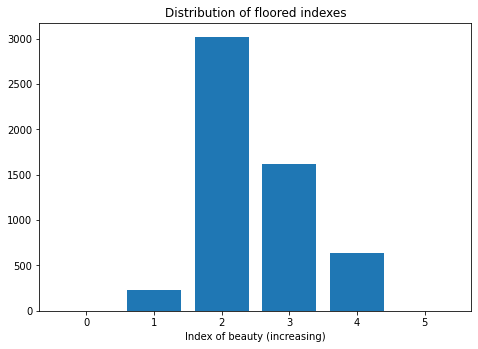

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['0','1', '2', '3', '4', '5']
students = [q,b,a,s,e,r]
ax.bar(langs,students)
plt.title('Distribution of floored indexes')
plt.xlabel('Index of beauty (increasing)')
plt.show()

In [0]:
X_show = [cv2.imread(PATH2+file) for file in tqdm(train_labels[:100,0])]

100%|██████████| 100/100 [00:00<00:00, 205.46it/s]


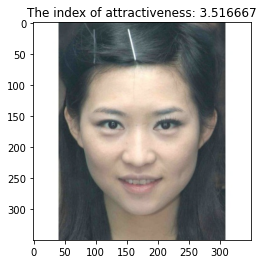

In [0]:
plt.imshow(imutils.opencv2matplotlib(X_show[99]))
plt.title('The index of attractiveness: {}'.format(str(y_train[0])))
plt.show()

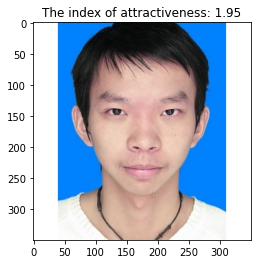

In [0]:
plt.imshow(imutils.opencv2matplotlib(X_show[4]))
plt.title('The index of attractiveness: {}'.format(str(y_train[4])))
plt.show()

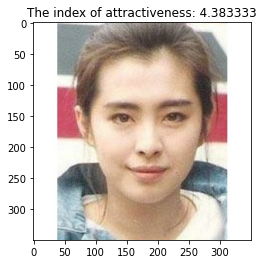

In [0]:
plt.imshow(imutils.opencv2matplotlib(X_show[7]))
plt.title('The index of attractiveness: {}'.format(str(y_train[7])))
plt.show()

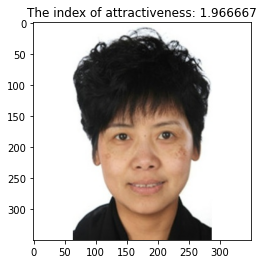

In [0]:
plt.imshow(imutils.opencv2matplotlib(X_show[8]))
plt.title('The index of attractiveness: {}'.format(str(y_train[8])))
plt.show()

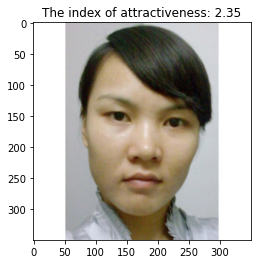

In [0]:
plt.imshow(imutils.opencv2matplotlib(X_show[9]))
plt.title('The index of attractiveness: {}'.format(str(y_train[9])))
plt.show()

In [0]:
class Beau:
    def __init__(self):

        self.model = Sequential()

        #1st 2dConvolutional Layer
        self.model.add(Conv2D(64, (3, 3), padding='same', input_shape=(160, 160, 1)))
        self.model.add(Activation('relu'))

        #1st 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))

        #2nd 2dConvolutional Layer
        self.model.add(Conv2D(64, (3, 3), padding='same'))
        self.model.add(Activation('relu'))

        #2nd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))

        #3rd 2dConvolutional Layer
        self.model.add(Conv2D(128, (5, 5), padding='same'))
        self.model.add(Activation('relu'))

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        #4th 2dConvolutional Layer
        self.model.add(Conv2D(128, (5, 5), padding='same'))
        self.model.add(Activation('relu'))

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        
        #5th 2dConvolutional Layer
        self.model.add(Conv2D(256, (3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        
        #6th 2dConvolutional Layer
        self.model.add(Conv2D(512, (5, 5), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(Flatten())

        #1st FC Layer
        self.model.add(Dense(256))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.25))
        
        #2nd FC Layer
        self.model.add(Dense(512))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.25))

        # Output layer
        self.model.add(Dense(1))
        self.model.add(Activation('relu'))

        self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
        self.model.summary()

In [0]:
model = Beau().model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 160, 160, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 80, 80, 64)        0

In [0]:
history = model.fit(X_train, y_train,
            batch_size=128,
            epochs=150,
            verbose=1,
            validation_data=(X_test, y_test))

Epoch 1/150
26/26 [==============================] - 5s 178ms/step - loss: 1.7139 - mean_squared_error: 1.7211 - val_loss: 9.3671 - val_mean_squared_error: 9.4244
Epoch 2/150
26/26 [==============================] - 3s 130ms/step - loss: 0.8152 - mean_squared_error: 0.8155 - val_loss: 9.3671 - val_mean_squared_error: 9.4244
Epoch 3/150
26/26 [==============================] - 3s 130ms/step - loss: 0.8196 - mean_squared_error: 0.8197 - val_loss: 9.2552 - val_mean_squared_error: 9.3073
Epoch 4/150
26/26 [==============================] - 3s 130ms/step - loss: 0.6968 - mean_squared_error: 0.6982 - val_loss: 7.0188 - val_mean_squared_error: 7.0751
Epoch 5/150
26/26 [==============================] - 3s 131ms/step - loss: 0.7826 - mean_squared_error: 0.7842 - val_loss: 3.8778 - val_mean_squared_error: 3.9338
Epoch 6/150
26/26 [==============================] - 3s 131ms/step - loss: 0.5836 - mean_squared_error: 0.5842 - val_loss: 2.0862 - val_mean_squared_error: 2.1174
Epoch 7/150
26/26 [===

Text(0.5, 0, 'Epoch')

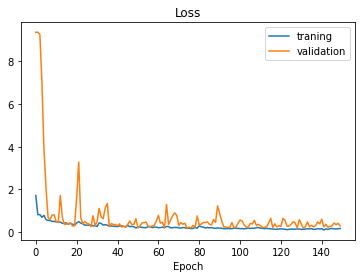

In [0]:
# import pickle
# file = open('/content/drive/My Drive/beauty_evaluate/beauty_evaluate/history.pickle','rb')
# data = pickle.load(file)
# file.close()

# val_loss,train_loss = data['val_loss'],data['loss']

# plt.figure(figsize=(10,6))
# plt.plot(np.arange(0,len(val_loss)),val_loss,label='validation')
# plt.plot(np.arange(0,len(val_loss)),train_loss,label='train')
# plt.xlabel('Number of epochs')
# plt.ylabel('Mean Squared Error value')
# plt.title('MSE as a function of epoch')
# plt.legend()
# plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model = Beau().model
model.load_weights("model2.h5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 160, 160, 64)      640       
_________________________________________________________________
activation_36 (Activation)   (None, 160, 160, 64)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
dropout_28 (Dropout)         (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 80, 80, 64)        36928     
_________________________________________________________________
activation_37 (Activation)   (None, 80, 80, 64)       

In [0]:
color = [(255,0,0),(0,255,255),(0,255,0),(0,100,255),(0,0,255)][::-1]
imagepath = './images/old.jpg'
face_clf = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
Model = Beau()
Model.model.load_weights('model2.h5')
image_name = imagepath.split('/')[-1]

img = cv2.imread(imagepath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_clf.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    fc = gray[y:y+h, x:x+w]

    roi = cv2.resize(fc, (160, 160))
    roi = roi.reshape((1,160,160,1))
    pred = Model.model.predict(roi)[0][0]

    cv2.putText(img, str(pred), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, color[math.floor(pred)], 2)
    cv2.rectangle(img,(x,y),(x+w,y+h),color[math.floor(pred)],2)

print(pred)
# cv2.imwrite('out'+image_name,img)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 160, 160, 64)      640       
_________________________________________________________________
activation_27 (Activation)   (None, 160, 160, 64)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
dropout_21 (Dropout)         (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 80, 80, 64)        36928     
_________________________________________________________________
activation_28 (Activation)   (None, 80, 80, 64)       

In [3]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json1", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk
